#### Flux with MNIST and GPU


##### Libraries

In [1]:
using CUDA

using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLJ                  # make_blobs, rmse, confmat, f1score, coerce
using MLDataUtils          # label, nlabel, labelfreq, stratifiedobs
using Flux                 # the julia ml library

using Plots
using Random
using DataFrames

In [2]:
include("../libs/libml.jl")

trainModel! (generic function with 1 method)

##### MNIST

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

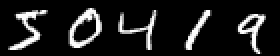

In [3]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2)  ; nrow=1)

In [4]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = MLDataUtils.stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

##### Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
tr_X, tr_y = preprocess(trainX, trainY)
d, N, size(tr_X), size(tr_y)

(784, 42001, (784, 42001), (10, 42001))

##### Model

In [6]:
# data on gpu
X_d = tr_X |> gpu
y_d = tr_y |> gpu;

In [7]:
# model configuration
nInputs  = d
nOutputs = 10

model = Chain( Flux.Dense(nInputs, 256, tanh),
               Flux.Dense(256, nOutputs, relu),
               softmax ) |> gpu                                      # weights on gpu

lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
data               = Flux.DataLoader((X_d, y_d), batchsize=1)      # batchsize=1 => SGD, batch size > 1 => batch gradient descent
modelOptimizer     = Flux.Descent()
callBack           = Flux.throttle(() -> println("training"), 10);   # print every 10s

##### Training

In [8]:
# trainModel!( lossFunction, modelParameters, data, modelOptimizer )   # libml

In [9]:
numberOfEpochs = 500

500

In [18]:
function stopCriteria(epoch::Int, tailLosses::Vector{Float64}, minDeltaLoss::Float64)
    if epoch < 3   return(false)   end

    if tailLosses[3] > tailLosses[2] && tailLosses[2] > tailLosses[1]
        # ver como voltar o modelo em 2 epochs
        return(true)
    end

    deltas = zeros(3)
    dt = abs( tailLosses[end-1] - tailLosses[end] )
    deltas[1] = deltas[2]
    deltas[2] = deltas[3]
    deltas[3] = dt
    display( (epoch, deltas) )
    if deltas[3] > deltas[2] && deltas[2] > deltas[1]   return(true)   end   # delta loss growing
    if dt < minDeltaLoss   return(true)   end                                # delta loss too small
end

stopCriteria (generic function with 1 method)

Training epoch with plotting, with the aid of homemade function trainModel!

In [11]:
# epochs      = 1 : numberOfEpochs
# epochLosses = Vector{Float32}()

# deltas = zeros(3)
# for epoch in epochs
#     l = trainModel!( lossFunction, modelParameters, data, modelOptimizer )   # libml
#     push!(epochLosses, l)

#     # exit criteria
#     if     epoch == 2
#         deltas[2] = abs( epochLosses[1] - epochLosses[2] )
#     elseif epoch == 3
#         deltas[3] = abs( epochLosses[2] - epochLosses[3] )
#     elseif epoch > 3
#         if epochLosses[end] > epochLosses[end-1]  &&  epochLosses[end-1] > epochLosses[end-2]   # loss function growing
#             # ver como voltar o modelo em 2 epochs
#             break
#         end

#         dt = abs( epochLosses[epoch-1] - epochLosses[epoch] )
#         deltas[1] = deltas[2]
#         deltas[2] = deltas[3]
#         deltas[3] = dt
#         # display( (epoch, deltas) )
#         if deltas[3] > deltas[2] && deltas[2] > deltas[1]   break   end   # delta loss growing
#         if dt < 1e-7   break   end                                        # delta loss too small
#     end

# end

In [19]:
epochs       = 1 : numberOfEpochs
epochLosses  = Vector{Float64}()
tailLosses   = zeros(3)
minDeltaLoss = 1e-7

for epoch in epochs
    l = trainModel!( lossFunction, modelParameters, data, modelOptimizer )   # libml
    push!(epochLosses, l)

    # exit criteria
    if epoch >= 3   tailLosses = epochLosses[end-2: end]   end
    if stopCriteria(epoch, tailLosses, minDeltaLoss)   break   end
end

(3, [0.0, 0.0, 0.00028694234788417816])

TypeError: TypeError: non-boolean (Nothing) used in boolean context

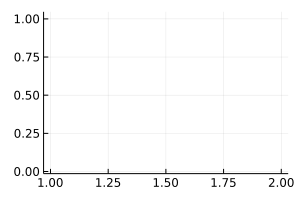

In [13]:
n = size(epochLosses)[1]
plot(epochs[1:n], epochLosses, size=(300,200), linewidth=2, legend=false)

##### Testing

In [14]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

predictOutcome (generic function with 1 method)

In [15]:
# preprocessing
ts_X, ts_y = preprocess(testX, testY)
X_d        = ts_X |> gpu

# predict
ŷ = predictOutcome(X_d)

# result
printMetrics( ŷ, coerce(testY, OrderedFactor) )

10×10 Matrix{Int64}:
 1737     0    20    12     6    32    24     4    29    18
    1  1953     5     1     5     7     1     4    36     2
    3    10  1616    24    15    16     6    25    47     7
   10    29    57  1728     7   133     0    11   333    47
    2     3    13     0  1537    28     3    12     2    19
    4     5     1    21     0  1333    15     1    52     6
   13     1    23     6    24    47  1725     1    28     2
    5    10    39    27    25    16     0  1803    31   170
    2     7     5     4     6     4     0     1  1166     3
    0     5     8    16   128    10     1    17    31  1511

accuracy: 0.895
f1-score: 

0.893
